In [1]:
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var

In [6]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

In [7]:
@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [8]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [9]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000  val_kld: 446.059  train_loss: 2898.078  train_kld: 276.395  val_log_var: -0.255  val_recon: 1903.660  val_mean: -0.003  train_recon: 2621.684  train_mean: -0.001  train_log_var: -0.167  val_loss: 2349.719  (8.59s - 77.29s remaining)


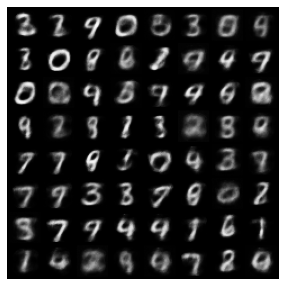

EPOCH: 2.000  val_kld: 567.347  train_loss: 2218.572  train_kld: 504.551  val_log_var: -0.346  val_recon: 1519.001  val_mean: 0.002  train_recon: 1714.021  train_mean: -0.001  train_log_var: -0.307  val_loss: 2086.348  (16.93s - 67.70s remaining)


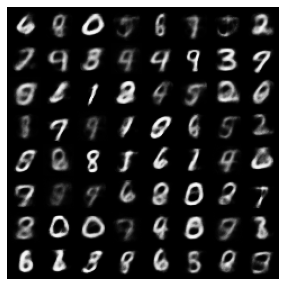

EPOCH: 3.000  val_kld: 565.125  train_loss: 2060.343  train_kld: 554.631  val_log_var: -0.348  val_recon: 1438.644  val_mean: -0.011  train_recon: 1505.711  train_mean: -0.001  train_log_var: -0.341  val_loss: 2003.769  (25.34s - 59.12s remaining)


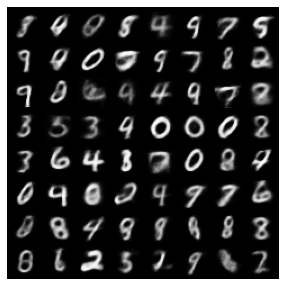

EPOCH: 4.000  val_kld: 588.702  train_loss: 1997.723  train_kld: 577.567  val_log_var: -0.360  val_recon: 1373.345  val_mean: -0.002  train_recon: 1420.156  train_mean: -0.001  train_log_var: -0.357  val_loss: 1962.047  (33.98s - 50.97s remaining)


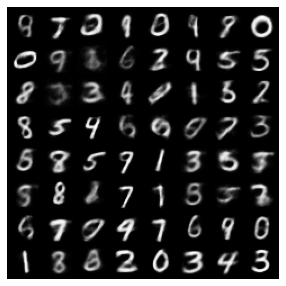

EPOCH: 5.000  val_kld: 615.771  train_loss: 1956.544  train_kld: 591.747  val_log_var: -0.385  val_recon: 1307.068  val_mean: -0.004  train_recon: 1364.797  train_mean: -0.001  train_log_var: -0.367  val_loss: 1922.840  (42.28s - 42.28s remaining)


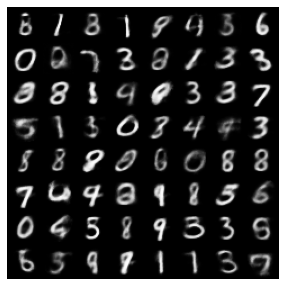

EPOCH: 6.000  val_kld: 601.684  train_loss: 1926.380  train_kld: 602.547  val_log_var: -0.371  val_recon: 1297.968  val_mean: -0.005  train_recon: 1323.833  train_mean: -0.001  train_log_var: -0.374  val_loss: 1899.652  (50.66s - 33.77s remaining)


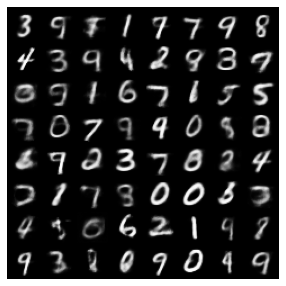

EPOCH: 7.000  val_kld: 625.812  train_loss: 1903.379  train_kld: 611.699  val_log_var: -0.388  val_recon: 1264.387  val_mean: -0.007  train_recon: 1291.680  train_mean: -0.001  train_log_var: -0.381  val_loss: 1890.199  (59.49s - 25.50s remaining)


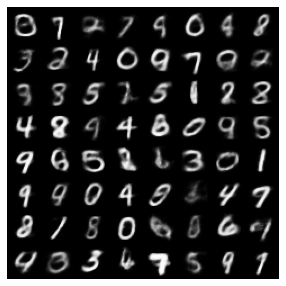

EPOCH: 8.000  val_kld: 641.537  train_loss: 1885.445  train_kld: 619.643  val_log_var: -0.395  val_recon: 1219.413  val_mean: 0.000  train_recon: 1265.802  train_mean: -0.000  train_log_var: -0.386  val_loss: 1860.950  (67.73s - 16.93s remaining)


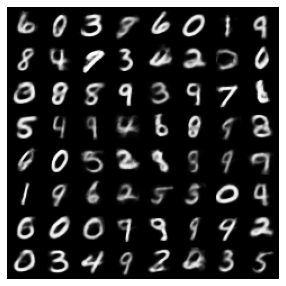

EPOCH: 9.000  val_kld: 614.888  train_loss: 1869.711  train_kld: 625.418  val_log_var: -0.381  val_recon: 1242.065  val_mean: -0.002  train_recon: 1244.293  train_mean: -0.000  train_log_var: -0.390  val_loss: 1856.953  (76.06s - 8.45s remaining)


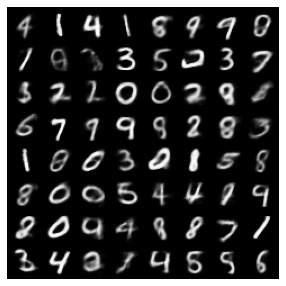

EPOCH: 10.000  val_kld: 632.544  train_loss: 1856.435  train_kld: 630.743  val_log_var: -0.394  val_recon: 1213.110  val_mean: -0.001  train_recon: 1225.692  train_mean: -0.000  train_log_var: -0.393  val_loss: 1845.654  (84.61s - 0.00s remaining)


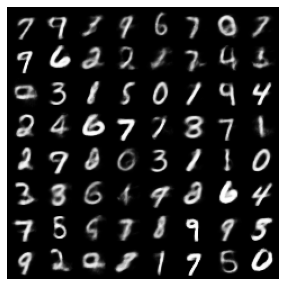

In [10]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)